<a href="https://colab.research.google.com/github/shiranthadiyago/Clustering-analysis-of-493-S-P-500-stocks/blob/main/Copy_of_CRM_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Loading - S&P 500 Stock Data

In [ ]:
# 1.1: Scrape S&P 500 ticker list from Wikipedia
print("Fetching S&P 500 ticker list from Wikipedia...")
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Add headers to mimic a browser request to avoid 403 Forbidden error
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
sp500_table = pd.read_html(url, storage_options=headers)
sp500_df = sp500_table[0]

# Extract ticker symbols
tickers = sp500_df['Symbol'].tolist()
print(f"Total tickers found: {len(tickers)}")
print(f"First 10 tickers: {tickers[:10]}")

Fetching S&P 500 ticker list from Wikipedia...
Total tickers found: 503
First 10 tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [ ]:
# 1.2: Download stock price data from Yahoo Finance
start_date = "2022-01-01"
end_date = "2025-01-01"

print(f"\nDownloading stock data from {start_date} to {end_date}...")
print("This may take a few minutes...\n")

# Dictionary to store valid stock data
stock_data = {}
failed_tickers = []

# Download data for each ticker
for i, ticker in enumerate(tickers):
    try:
        # Download historical data, explicitly setting auto_adjust=False
        # and then selecting 'Adj Close' column.
        data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)

        # Check if data is valid (not empty and has enough data points)
        if not data.empty and len(data) > 100:  # At least 100 trading days
            if 'Adj Close' in data.columns:
                stock_data[ticker] = data['Adj Close']  # Store adjusted close prices
            elif 'Close' in data.columns: # Fallback to 'Close' if 'Adj Close' is not available
                stock_data[ticker] = data['Close']
            else:
                raise ValueError("Neither 'Adj Close' nor 'Close' column found.")

            if (i + 1) % 50 == 0:
                print(f"Progress: {i + 1}/{len(tickers)} tickers processed...")
        else:
            failed_tickers.append(ticker)

    except Exception as e:
        failed_tickers.append(ticker)
        print(f"Failed to download {ticker}: {type(e).__name__} - {str(e)}")

print(f"\n{'='*60}")
print(f"Data Loading Complete!")
print(f"{'='*60}")
print(f"Successfully downloaded: {len(stock_data)} tickers")
print(f"Failed downloads: {len(failed_tickers)} tickers")

if failed_tickers:
    print(f"\nFailed tickers: {failed_tickers[:10]}{'...' if len(failed_tickers) > 10 else ''}")


This may take a few minutes...

Progress: 50/503 tickers processed...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01)')


Progress: 100/503 tickers processed...
Progress: 150/503 tickers processed...
Progress: 200/503 tickers processed...
Progress: 250/503 tickers processed...
Progress: 300/503 tickers processed...
Progress: 350/503 tickers processed...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1641013200, endDate = 1735707600")')


Progress: 400/503 tickers processed...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1641013200, endDate = 1735707600")')


Progress: 450/503 tickers processed...
Progress: 500/503 tickers processed...

Data Loading Complete!
Successfully downloaded: 499 tickers
Failed downloads: 4 tickers

Failed tickers: ['BRK.B', 'BF.B', 'Q', 'SOLS']


In [ ]:
# 1.3: Create a DataFrame with all valid stock prices
# Use pd.concat for more robust DataFrame creation from a dictionary of Series
if stock_data:
    prices_df = pd.concat(stock_data.values(), axis=1, keys=stock_data.keys())
else:
    prices_df = pd.DataFrame() # Create an empty DataFrame if no data was loaded

# Display basic information
print(f"\nDataFrame Shape: {prices_df.shape}")
# Check if prices_df is not empty before trying to access its index
if not prices_df.empty:
    print(f"Date Range: {prices_df.index[0]} to {prices_df.index[-1]}")
    print(f"\nFirst few rows:")
    print(prices_df.head())

    # Check for missing values
    missing_pct = (prices_df.isnull().sum() / len(prices_df) * 100).sort_values(ascending=False)
    print(f"\nTop 10 stocks with missing data (%):")
    print(missing_pct.head(10))

    # Summary statistics
    print(f"\nSummary Statistics:")
    print(prices_df.describe())

    print("\n✓ Step 1 Complete: Data successfully loaded and stored in 'prices_df'")
else:
    print("\nNo stock data was successfully downloaded. 'prices_df' is empty.")


DataFrame Shape: (753, 499)
Date Range: 2022-01-03 00:00:00 to 2024-12-31 00:00:00

First few rows:
                   MMM        AOS         ABT        ABBV         ACN  \
Ticker             MMM        AOS         ABT        ABBV         ACN   
Date                                                                    
2022-01-03  128.075943  77.668457  128.996155  116.779297  383.712036   
2022-01-04  129.870148  78.960312  125.962357  116.555092  380.969849   
2022-01-05  129.336929  77.640594  125.396393  117.167343  374.260681   
2022-01-06  128.263245  78.161049  125.377831  116.615456  356.187469   
2022-01-07  129.668365  77.278137  125.767525  116.313637  349.355896   

                  ADBE         AMD        AES        AFL           A  ...  \
Ticker            ADBE         AMD        AES        AFL           A  ...   
Date                                                                  ...   
2022-01-03  564.369995  150.240005  20.777491  53.432285  152.320038  ...   
2022-0

# Step 2: Calculate Financial Metrics

In [ ]:
# 2.1: Handle Missing Data
print("\n[1/5] Handling Missing Data...")

# Calculate percentage of missing data for each stock
missing_pct = (prices_df.isnull().sum() / len(prices_df) * 100)

# Remove stocks with more than 20% missing data
threshold = 20
stocks_to_remove = missing_pct[missing_pct > threshold].index.tolist()
print(f"Removing {len(stocks_to_remove)} stocks with >{threshold}% missing data:")
print(f"  {stocks_to_remove}")

# Keep only valid stocks
prices_clean = prices_df.drop(columns=stocks_to_remove)

# Forward-fill remaining missing values (carry forward last known price)
prices_clean = prices_clean.fillna(method='ffill')

# Drop any remaining rows with NaN (if any at the beginning)
prices_clean = prices_clean.dropna(axis=1)

print(f"Cleaned DataFrame Shape: {prices_clean.shape}")
print(f"Remaining stocks: {prices_clean.shape[1]}")


[1/5] Handling Missing Data...
Removing 5 stocks with >20% missing data:
  [('GEHC', 'GEHC'), ('GEV', 'GEV'), ('KVUE', 'KVUE'), ('SOLV', 'SOLV'), ('VLTO', 'VLTO')]
Cleaned DataFrame Shape: (753, 493)
Remaining stocks: 493


/tmp/ipython-input-4068434181.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices_clean = prices_clean.fillna(method='ffill')


In [ ]:
# 2.2: Download S&P 500 Index (^GSPC) for Beta Calculation
print("\n[2/5] Downloading S&P 500 Index (^GSPC) data...")

try:
    # Download with auto_adjust=False to ensure 'Adj Close' is present, or fallback to 'Close'
    data_sp500 = yf.download('^GSPC', start='2022-01-01', end='2025-01-01', progress=False, auto_adjust=False)

    if 'Adj Close' in data_sp500.columns:
        sp500_index = data_sp500['Adj Close']
    elif 'Close' in data_sp500.columns:
        sp500_index = data_sp500['Close']
    else:
        raise ValueError("Neither 'Adj Close' nor 'Close' column found for ^GSPC.")

    print(f"Index data downloaded: {len(sp500_index)} data points")
    print(f"Date range: {sp500_index.index[0]} to {sp500_index.index[-1]}")
except Exception as e:
    print(f"Error downloading index: {e}")


[2/5] Downloading S&P 500 Index (^GSPC) data...
Index data downloaded: 753 data points
Date range: 2022-01-03 00:00:00 to 2024-12-31 00:00:00


In [ ]:
# 2.3: Calculate Daily Returns
print("\n[3/5] Calculating Daily Returns...")

# Calculate daily returns for all stocks
# Formula: (Price_today - Price_yesterday) / Price_yesterday
daily_returns = prices_clean.pct_change()

# Drop the first row (NaN values from pct_change)
daily_returns = daily_returns.dropna()

# Calculate daily returns for S&P 500 index
market_returns = sp500_index.pct_change().dropna()

# Align dates between stocks and market index
common_dates = daily_returns.index.intersection(market_returns.index)
daily_returns = daily_returns.loc[common_dates]
market_returns = market_returns.loc[common_dates]

print(f"Daily returns calculated for {daily_returns.shape[1]} stocks")
print(f"Number of trading days: {daily_returns.shape[0]}")
print(f"\nSample daily returns (first 5 rows, first 5 stocks):")
print(daily_returns.iloc[:5, :5])


[3/5] Calculating Daily Returns...
Daily returns calculated for 493 stocks
Number of trading days: 752

Sample daily returns (first 5 rows, first 5 stocks):
                 MMM       AOS       ABT      ABBV       ACN
Ticker           MMM       AOS       ABT      ABBV       ACN
Date                                                        
2022-01-04  0.014009  0.016633 -0.023519 -0.001920 -0.007146
2022-01-05 -0.004106 -0.016714 -0.004493  0.005253 -0.017611
2022-01-06 -0.008301  0.006703 -0.000148 -0.004710 -0.048290
2022-01-07  0.010955 -0.011296  0.003108 -0.002588 -0.019180
2022-01-10 -0.014115 -0.003127 -0.002213  0.011195  0.006069


In [ ]:
# 2.4: Calculate Beta for Each Stock
print("\n[4/5] Calculating Beta...")

beta_values = {}
# Ensure market_returns is a 1D Series before calculating variance
market_variance = np.var(market_returns.squeeze())

for ticker in daily_returns.columns:
    # Calculate covariance between stock and market, ensuring both are 1D Series
    covariance = np.cov(daily_returns[ticker], market_returns.squeeze())[0, 1]

    # Beta = Covariance(stock, market) / Variance(market)
    beta = covariance / market_variance
    beta_values[ticker] = beta

print(f"Beta calculated for {len(beta_values)} stocks")
print(f"Sample Beta values:")
for i, (ticker, beta) in enumerate(list(beta_values.items())[:5]):
    print(f"  {ticker}: {beta:.3f}")


[4/5] Calculating Beta...
Beta calculated for 493 stocks
Sample Beta values:
  ('MMM', 'MMM'): 0.785
  ('AOS', 'AOS'): 0.926
  ('ABT', 'ABT'): 0.673
  ('ABBV', 'ABBV'): 0.299
  ('ACN', 'ACN'): 1.096


In [ ]:
# 2.5: Calculate Annual Volatility
print("\n[5/5] Calculating Annual Volatility...")

volatility_values = {}
trading_days_per_year = 252

for ticker in daily_returns.columns:
    # Calculate standard deviation of daily returns
    daily_std = np.std(daily_returns[ticker])

    # Annualize volatility: σ_annual = σ_daily × √252
    annual_volatility = daily_std * np.sqrt(trading_days_per_year)
    volatility_values[ticker] = annual_volatility

print(f"Volatility calculated for {len(volatility_values)} stocks")
print(f"Sample Volatility values:")
for i, (ticker, vol) in enumerate(list(volatility_values.items())[:5]):
    print(f"  {ticker}: {vol:.3f} ({vol*100:.2f}%)")


[5/5] Calculating Annual Volatility...
Volatility calculated for 493 stocks
Sample Volatility values:
  ('MMM', 'MMM'): 0.295 (29.55%)
  ('AOS', 'AOS'): 0.278 (27.85%)
  ('ABT', 'ABT'): 0.218 (21.77%)
  ('ABBV', 'ABBV'): 0.220 (21.98%)
  ('ACN', 'ACN'): 0.270 (27.02%)


In [ ]:
# 2.6: Calculate Mean Daily Return
print("\n[6/5] Calculating Mean Daily Return...")

mean_return_values = {}

for ticker in daily_returns.columns:
    mean_daily_return = np.mean(daily_returns[ticker])
    mean_return_values[ticker] = mean_daily_return



[6/5] Calculating Mean Daily Return...


In [ ]:
# 2.7: Create Summary DataFrame
print("\n[Final] Creating Metrics Summary DataFrame...")

metrics_df = pd.DataFrame({
    'Ticker': list(beta_values.keys()),
    'Beta': list(beta_values.values()),
    'Volatility': list(volatility_values.values()),
    'Mean_Daily_Return': list(mean_return_values.values())
})

# Add annualized return for reference
metrics_df['Annualized_Return'] = metrics_df['Mean_Daily_Return'] * trading_days_per_year

print(f"\nMetrics DataFrame Shape: {metrics_df.shape}")
print(f"\nFirst 10 rows of metrics:")
print(metrics_df.head(10))

print("\n" + "="*60)
print("Summary Statistics of Metrics:")
print("="*60)
print(metrics_df.describe())

# Additional insights
print("\n" + "="*60)
print("Key Insights:")
print("="*60)
print(f"Stocks with Beta > 1.5 (High Risk): {len(metrics_df[metrics_df['Beta'] > 1.5])}")
print(f"Stocks with Beta < 0.5 (Low Risk): {len(metrics_df[metrics_df['Beta'] < 0.5])}")
print(f"Stocks with Volatility > 0.5 (50%): {len(metrics_df[metrics_df['Volatility'] > 0.5])}")
print(f"Stocks with Volatility < 0.2 (20%): {len(metrics_df[metrics_df['Volatility'] < 0.2])}")

print("\nTop 5 Highest Beta Stocks:")
print(metrics_df.nlargest(5, 'Beta')[['Ticker', 'Beta', 'Volatility']])

print("\nTop 5 Most Volatile Stocks:")
print(metrics_df.nlargest(5, 'Volatility')[['Ticker', 'Beta', 'Volatility']])

print("\nTop 5 Least Volatile Stocks:")
print(metrics_df.nsmallest(5, 'Volatility')[['Ticker', 'Beta', 'Volatility']])

print("\n✓ Step 2 Complete: Financial metrics calculated and stored in 'metrics_df'")
print(f"✓ Daily returns stored in 'daily_returns' DataFrame")


[Final] Creating Metrics Summary DataFrame...

Metrics DataFrame Shape: (493, 5)

First 10 rows of metrics:
         Ticker      Beta  Volatility  Mean_Daily_Return  Annualized_Return
0    (MMM, MMM)  0.784780    0.295457           0.000160           0.040413
1    (AOS, AOS)  0.925682    0.278488          -0.000047          -0.011743
2    (ABT, ABT)  0.673212    0.217694          -0.000106          -0.026648
3  (ABBV, ABBV)  0.299497    0.219811           0.000610           0.153699
4    (ACN, ACN)  1.095665    0.270152           0.000011           0.002679
5  (ADBE, ADBE)  1.449902    0.382828          -0.000022          -0.005458
6    (AMD, AMD)  2.067498    0.523839           0.000254           0.064130
7    (AES, AES)  1.017249    0.357208          -0.000462          -0.116398
8    (AFL, AFL)  0.608589    0.213861           0.000948           0.238867
9        (A, A)  1.026164    0.296062          -0.000002          -0.000397

Summary Statistics of Metrics:
             Beta  Vola

# Step 3: Agglomerative (Hierarchical) Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

print("="*60)
print("Step 3: Agglomerative Clustering")
print("="*60)


Step 3: Agglomerative Clustering


In [ ]:
# 3.1: Prepare Features for Clustering
print("\n[1/6] Preparing Features...")

# Select features for clustering
features = ['Beta', 'Volatility', 'Mean_Daily_Return']
X = metrics_df[features].values

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {features}")
print(f"\nFeature ranges before scaling:")
for i, feature in enumerate(features):
    print(f"  {feature}: min={X[:, i].min():.4f}, max={X[:, i].max():.4f}")



[1/6] Preparing Features...
Feature matrix shape: (493, 3)
Features used: ['Beta', 'Volatility', 'Mean_Daily_Return']

Feature ranges before scaling:
  Beta: min=0.1091, max=2.9649
  Volatility: min=0.1561, max=0.9532
  Mean_Daily_Return: min=-0.0017, max=0.0041


In [ ]:
# 3.2: Standardize Features
print("\n[2/6] Standardizing Features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"\nFeature ranges after scaling (should be ~0 mean, ~1 std):")
for i, feature in enumerate(features):
    print(f"  {feature}: mean={X_scaled[:, i].mean():.4f}, std={X_scaled[:, i].std():.4f}")



[2/6] Standardizing Features...
Scaled feature matrix shape: (493, 3)

Feature ranges after scaling (should be ~0 mean, ~1 std):
  Beta: mean=-0.0000, std=1.0000
  Volatility: mean=0.0000, std=1.0000
  Mean_Daily_Return: mean=0.0000, std=1.0000



[3/6] Creating Dendrogram...
✓ Dendrogram saved as 'dendrogram.png'


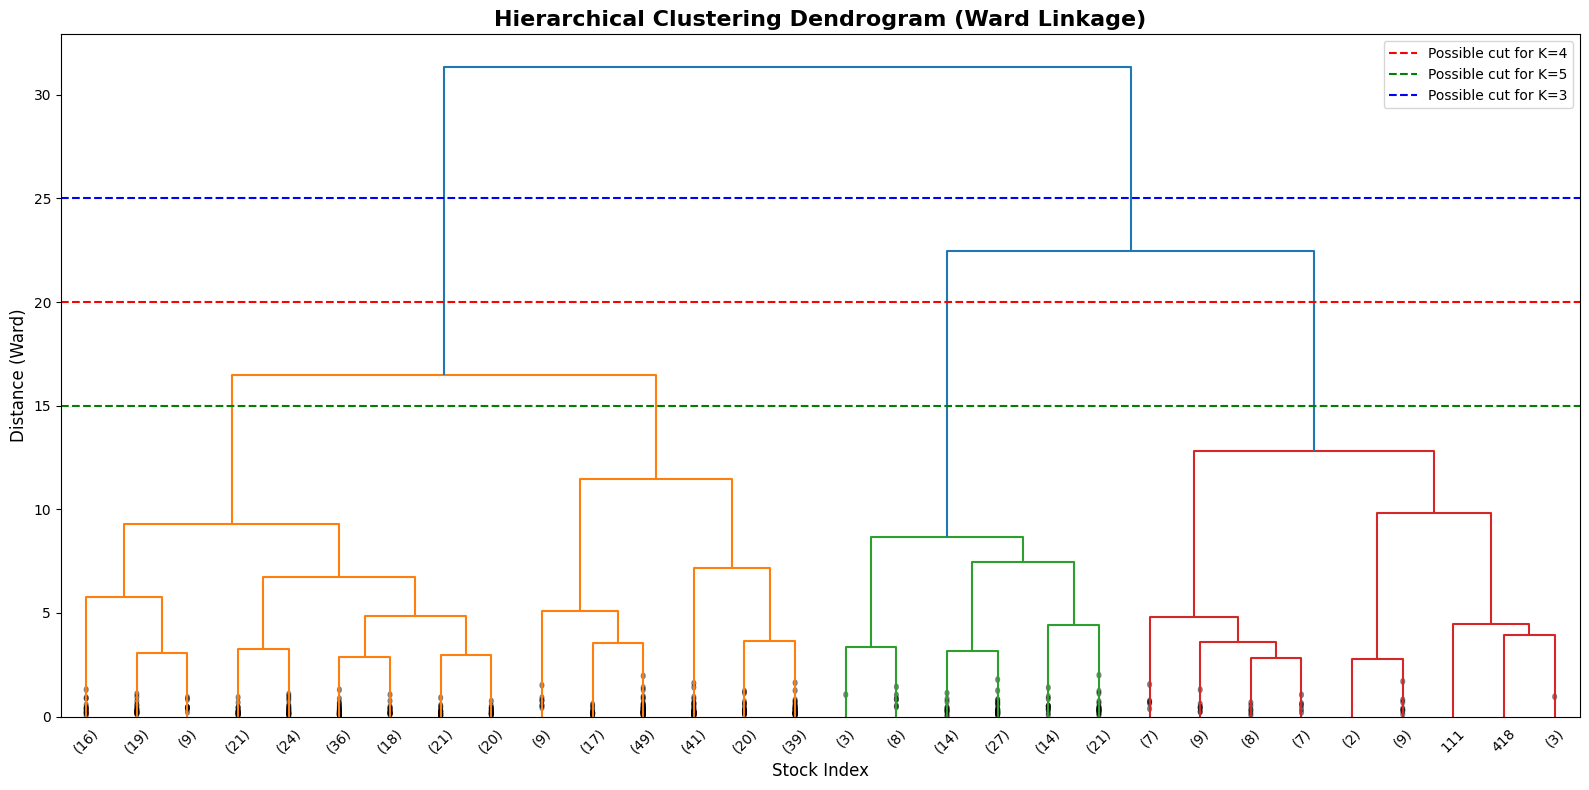

In [ ]:
# 3.3: Create Dendrogram to Determine Optimal K
print("\n[3/6] Creating Dendrogram...")

# Perform hierarchical clustering with Ward linkage
linkage_matrix = linkage(X_scaled, method='ward')

# Create figure for dendrogram
plt.figure(figsize=(16, 8))
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=16, fontweight='bold')
plt.xlabel('Stock Index', fontsize=12)
plt.ylabel('Distance (Ward)', fontsize=12)

# Plot dendrogram
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Show only last p merged clusters
    p=30,  # Show last 30 merges
    leaf_font_size=10,
    show_contracted=True
)

plt.axhline(y=20, color='r', linestyle='--', label='Possible cut for K=4')
plt.axhline(y=15, color='g', linestyle='--', label='Possible cut for K=5')
plt.axhline(y=25, color='b', linestyle='--', label='Possible cut for K=3')
plt.legend()
plt.tight_layout()
plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
print("✓ Dendrogram saved as 'dendrogram.png'")
plt.show()


In [ ]:
# 3.4: Perform Agglomerative Clustering with Different K Values
print("\n[4/6] Performing Agglomerative Clustering...")

# Test with K=3, 4, 5
k_values = [3, 4, 5]
clustering_results = {}

for k in k_values:
    print(f"\n--- Testing K={k} clusters ---")

    # Apply Agglomerative Clustering
    agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agg_cluster.fit_predict(X_scaled)

    # Add cluster labels to metrics_df
    metrics_df[f'Cluster_K{k}'] = cluster_labels

    # Store results
    clustering_results[k] = cluster_labels

    # Print cluster sizes
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"Cluster sizes:")
    for cluster_id, count in zip(unique, counts):
        print(f"  Cluster {cluster_id}: {count} stocks ({count/len(cluster_labels)*100:.1f}%)")



[4/6] Performing Agglomerative Clustering...

--- Testing K=3 clusters ---
Cluster sizes:
  Cluster 0: 359 stocks (72.8%)
  Cluster 1: 47 stocks (9.5%)
  Cluster 2: 87 stocks (17.6%)

--- Testing K=4 clusters ---
Cluster sizes:
  Cluster 0: 47 stocks (9.5%)
  Cluster 1: 175 stocks (35.5%)
  Cluster 2: 87 stocks (17.6%)
  Cluster 3: 184 stocks (37.3%)

--- Testing K=5 clusters ---
Cluster sizes:
  Cluster 0: 175 stocks (35.5%)
  Cluster 1: 16 stocks (3.2%)
  Cluster 2: 87 stocks (17.6%)
  Cluster 3: 184 stocks (37.3%)
  Cluster 4: 31 stocks (6.3%)


In [ ]:
# 3.5: Analyze Clusters (using K=4 as primary analysis)
print("\n[5/6] Analyzing Clusters (K=4)...")

K_OPTIMAL = 4  # You can change this based on dendrogram
cluster_col = f'Cluster_K{K_OPTIMAL}'

print(f"\nUsing K={K_OPTIMAL} for detailed analysis")
print("="*60)

# Calculate mean metrics for each cluster
cluster_analysis = metrics_df.groupby(cluster_col)[features].mean()
cluster_analysis['Count'] = metrics_df.groupby(cluster_col).size()
cluster_analysis['Annualized_Return_Mean'] = metrics_df.groupby(cluster_col)['Annualized_Return'].mean()

print("\nCluster Characteristics (Mean Values):")
print(cluster_analysis.round(4))

# Interpret each cluster
print("\n" + "="*60)
print("CLUSTER INTERPRETATION FOR INVESTORS:")
print("="*60)

for cluster_id in range(K_OPTIMAL):
    cluster_data = cluster_analysis.loc[cluster_id]

    print(f"\n🔹 CLUSTER {cluster_id} ({int(cluster_data['Count'])} stocks):")
    print(f"   Beta: {cluster_data['Beta']:.3f}")
    print(f"   Volatility: {cluster_data['Volatility']:.3f} ({cluster_data['Volatility']*100:.1f}%)")
    print(f"   Mean Daily Return: {cluster_data['Mean_Daily_Return']:.6f}")
    print(f"   Annualized Return: {cluster_data['Annualized_Return_Mean']:.3f} ({cluster_data['Annualized_Return_Mean']*100:.1f}%)")

    # Interpretation logic
    beta = cluster_data['Beta']
    vol = cluster_data['Volatility']

    if beta < 0.7 and vol < 0.25:
        risk_type = "🟢 DEFENSIVE/LOW RISK"
        description = "Stable stocks with low market sensitivity. Good for risk-averse investors."
        examples = "Utilities, Consumer Staples, Healthcare"
    elif beta > 1.3 and vol > 0.4:
        risk_type = "🔴 AGGRESSIVE/HIGH RISK"
        description = "High-growth stocks with high volatility. Suitable for risk-tolerant investors."
        examples = "Tech, Semiconductors, Crypto-related"
    elif beta >= 0.7 and beta <= 1.3:
        risk_type = "🟡 MODERATE RISK"
        description = "Balanced stocks that move with the market. Good for diversified portfolios."
        examples = "Industrials, Financials, Consumer Discretionary"
    else:
        risk_type = "🟠 SPECIAL SITUATION"
        description = "Unusual risk/return profile. Requires individual analysis."
        examples = "Varies"

    print(f"   Type: {risk_type}")
    print(f"   Description: {description}")
    print(f"   Typical Sectors: {examples}")

    # Show top 5 stocks in this cluster
    cluster_stocks = metrics_df[metrics_df[cluster_col] == cluster_id].nlargest(5, 'Beta')
    print(f"   Sample Stocks: {', '.join([str(t) for t in cluster_stocks['Ticker'].head(5).values])}")



[5/6] Analyzing Clusters (K=4)...

Using K=4 for detailed analysis

Cluster Characteristics (Mean Values):
              Beta  Volatility  Mean_Daily_Return  Count  \
Cluster_K4                                                 
0           1.6393      0.5059             0.0014     47   
1           0.5627      0.2394             0.0002    175   
2           1.2765      0.3944            -0.0002     87   
3           0.9478      0.2890             0.0006    184   

            Annualized_Return_Mean  
Cluster_K4                          
0                           0.3590  
1                           0.0504  
2                          -0.0447  
3                           0.1564  

CLUSTER INTERPRETATION FOR INVESTORS:

🔹 CLUSTER 0 (47 stocks):
   Beta: 1.639
   Volatility: 0.506 (50.6%)
   Mean Daily Return: 0.001425
   Annualized Return: 0.359 (35.9%)
   Type: 🔴 AGGRESSIVE/HIGH RISK
   Description: High-growth stocks with high volatility. Suitable for risk-tolerant investors.
   Typ


[6/6] Creating Visualizations...
✓ Cluster visualization saved as 'agglomerative_clusters.png'


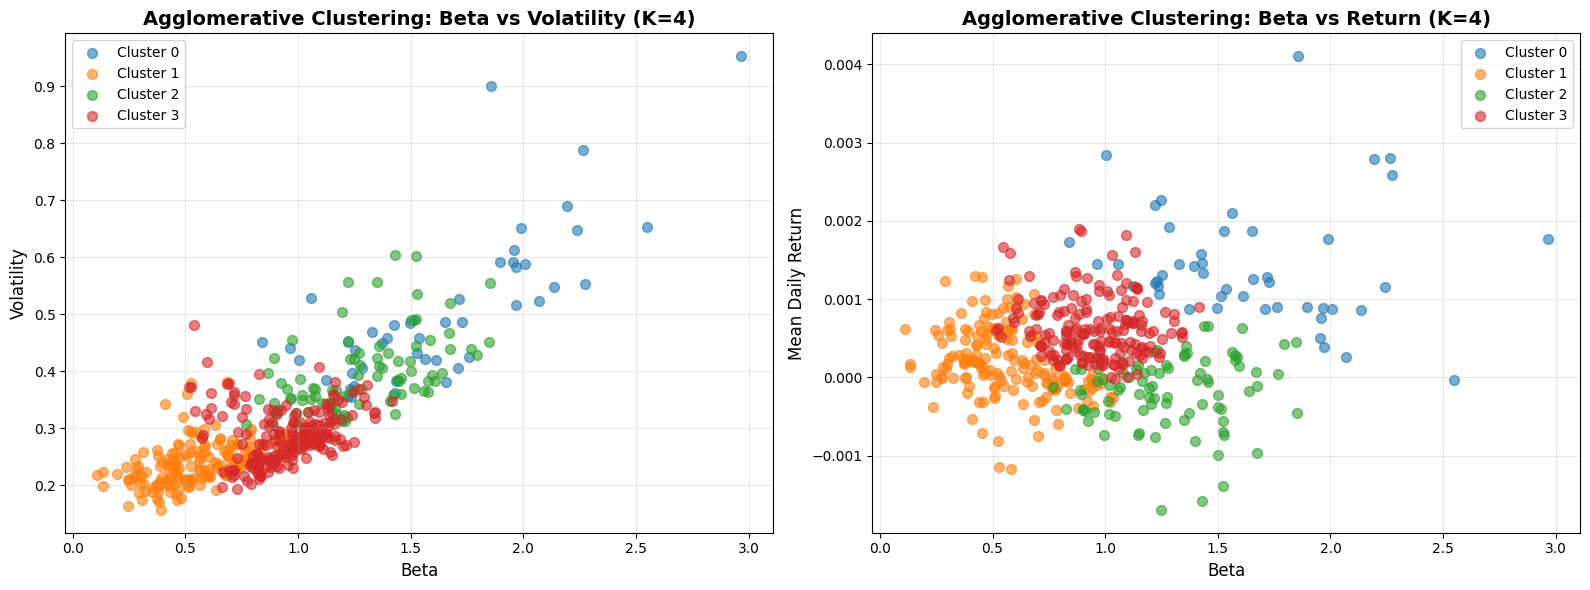

/tmp/ipython-input-1139548059.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[f'C{i}' for i in range(K_OPTIMAL)])
/tmp/ipython-input-1139548059.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[f'C{i}' for i in range(K_OPTIMAL)])
/tmp/ipython-input-1139548059.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[f'C{i}' for i in range(K_OPTIMAL)])


✓ Box plots saved as 'cluster_boxplots.png'


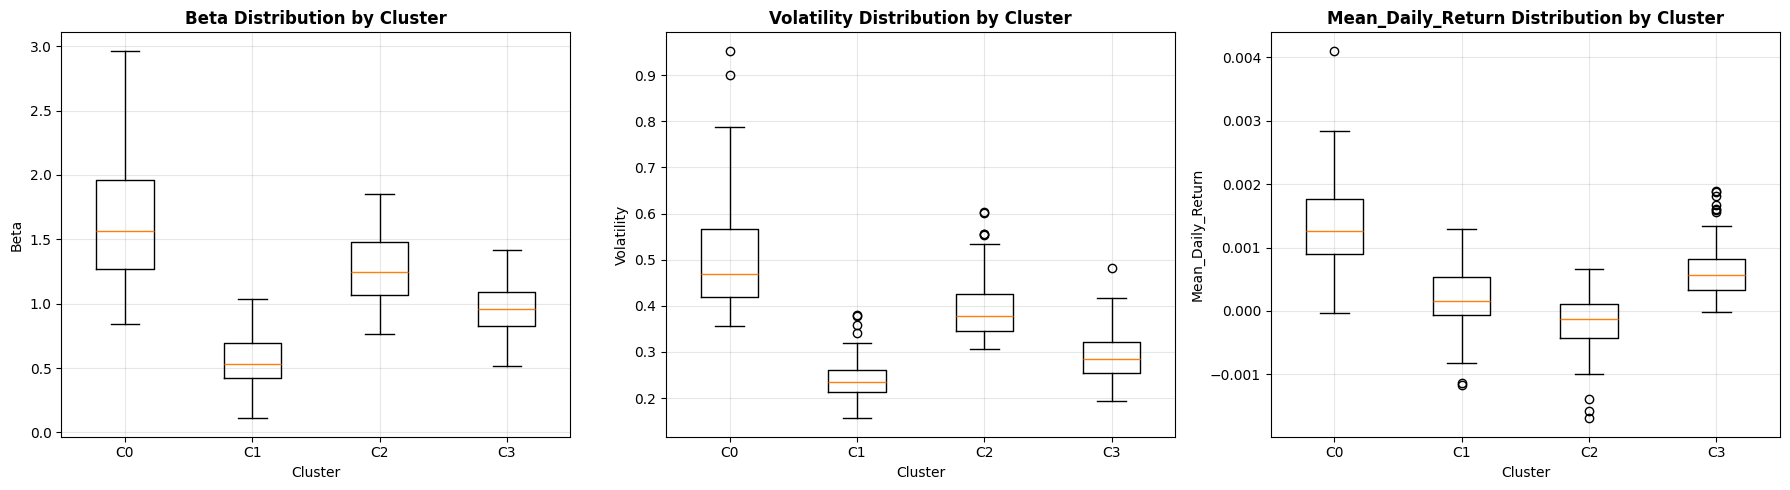


✓ Step 3 Complete: Agglomerative Clustering Finished!
✓ Optimal K chosen: 4
✓ Cluster labels added to 'metrics_df' as 'Cluster_K4'
✓ Visualizations saved as PNG files

For portfolio diversification:
  → Mix stocks from different clusters to reduce risk
  → Low-risk clusters: Core holdings (60-70%)
  → Medium-risk clusters: Growth component (20-30%)
  → High-risk clusters: Opportunistic positions (5-10%)


In [ ]:
# 3.6: Visualize Clusters
print("\n[6/6] Creating Visualizations...")

# Create scatter plot: Beta vs Volatility
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Beta vs Volatility
for cluster_id in range(K_OPTIMAL):
    cluster_data = metrics_df[metrics_df[cluster_col] == cluster_id]
    axes[0].scatter(
        cluster_data['Beta'],
        cluster_data['Volatility'],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50
    )

axes[0].set_xlabel('Beta', fontsize=12)
axes[0].set_ylabel('Volatility', fontsize=12)
axes[0].set_title(f'Agglomerative Clustering: Beta vs Volatility (K={K_OPTIMAL})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Beta vs Mean Daily Return
for cluster_id in range(K_OPTIMAL):
    cluster_data = metrics_df[metrics_df[cluster_col] == cluster_id]
    axes[1].scatter(
        cluster_data['Beta'],
        cluster_data['Mean_Daily_Return'],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50
    )

axes[1].set_xlabel('Beta', fontsize=12)
axes[1].set_ylabel('Mean Daily Return', fontsize=12)
axes[1].set_title(f'Agglomerative Clustering: Beta vs Return (K={K_OPTIMAL})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('agglomerative_clusters.png', dpi=300, bbox_inches='tight')
print("✓ Cluster visualization saved as 'agglomerative_clusters.png'")
plt.show()

# Box plots for each feature by cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(features):
    data_to_plot = [metrics_df[metrics_df[cluster_col] == i][feature].values
                    for i in range(K_OPTIMAL)]

    axes[idx].boxplot(data_to_plot, labels=[f'C{i}' for i in range(K_OPTIMAL)])
    axes[idx].set_title(f'{feature} Distribution by Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_boxplots.png', dpi=300, bbox_inches='tight')
print("✓ Box plots saved as 'cluster_boxplots.png'")
plt.show()

print("\n" + "="*60)
print("✓ Step 3 Complete: Agglomerative Clustering Finished!")
print("="*60)
print(f"✓ Optimal K chosen: {K_OPTIMAL}")
print(f"✓ Cluster labels added to 'metrics_df' as 'Cluster_K{K_OPTIMAL}'")
print(f"✓ Visualizations saved as PNG files")
print("\nFor portfolio diversification:")
print("  → Mix stocks from different clusters to reduce risk")
print("  → Low-risk clusters: Core holdings (60-70%)")
print("  → Medium-risk clusters: Growth component (20-30%)")
print("  → High-risk clusters: Opportunistic positions (5-10%)")

# Step 4: K-Means Clustering

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples

print("="*60)
print("Step 4: K-Means Clustering")
print("="*60)

Step 4: K-Means Clustering


In [ ]:
# 4.1: Use Same Standardized Features from Step 3
print("\n[1/7] Using Standardized Features...")

# We already have X_scaled from Step 3, but let's confirm
print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Features: {features}")



[1/7] Using Standardized Features...
Feature matrix shape: (493, 3)
Features: ['Beta', 'Volatility', 'Mean_Daily_Return']



[2/7] Applying Elbow Method...
K=2: WCSS=922.19, Silhouette=0.449, DB=1.061
K=3: WCSS=707.10, Silhouette=0.333, DB=1.076
K=4: WCSS=565.47, Silhouette=0.299, DB=1.060
K=5: WCSS=480.08, Silhouette=0.292, DB=0.997
K=6: WCSS=409.14, Silhouette=0.295, DB=1.002
K=7: WCSS=364.80, Silhouette=0.296, DB=0.932
K=8: WCSS=323.27, Silhouette=0.290, DB=0.950
K=9: WCSS=288.65, Silhouette=0.293, DB=0.937
K=10: WCSS=263.35, Silhouette=0.288, DB=0.937

✓ Optimal K analysis saved as 'kmeans_optimal_k.png'


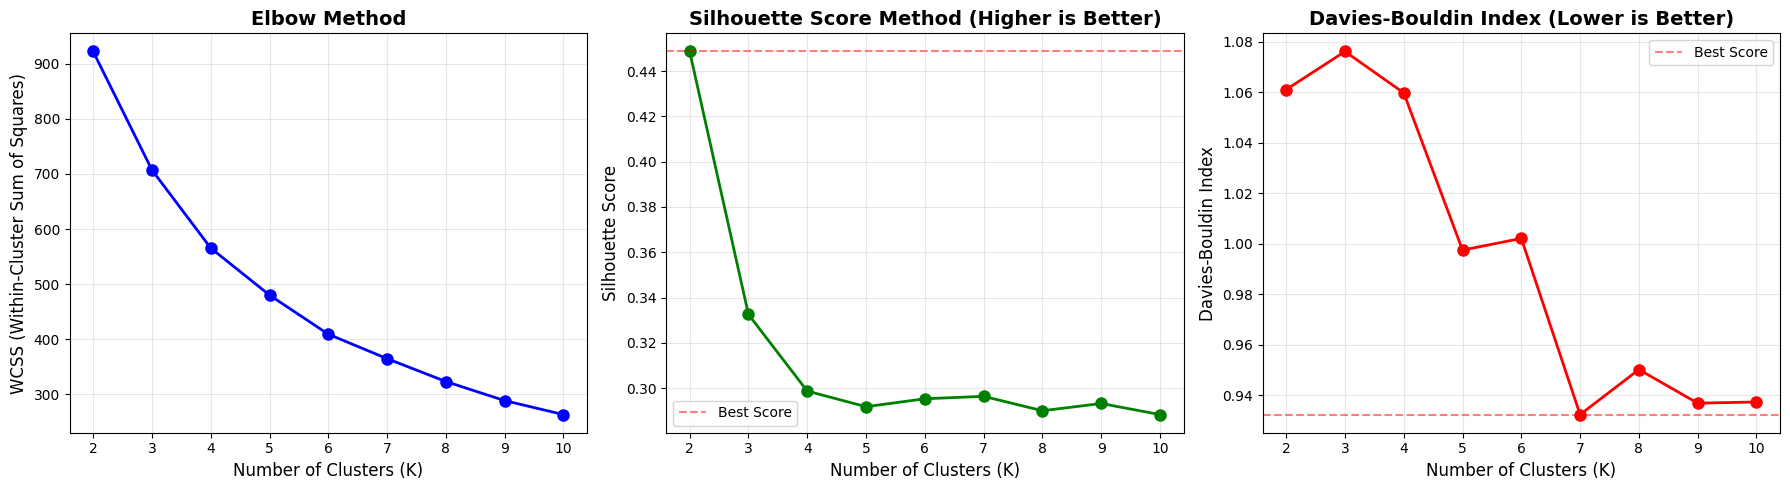


OPTIMAL K DETERMINATION:
Best K by Silhouette Score: 2 (Score: 0.449)
Best K by Davies-Bouldin: 7 (Score: 0.932)
Recommendation: Use K=2 (based on Silhouette)


In [ ]:
# 4.2: Elbow Method - Find Optimal K
print("\n[2/7] Applying Elbow Method...")

# Test K from 2 to 10
k_range = range(2, 11)
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []
db_scores = []  # Davies-Bouldin scores

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

    print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}, DB={db_scores[-1]:.3f}")

# Plot Elbow Method
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: WCSS (Elbow Method)
axes[0].plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Plot 2: Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score Method (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=max(silhouette_scores), color='r', linestyle='--', alpha=0.5, label='Best Score')
axes[1].legend()

# Plot 3: Davies-Bouldin Index
axes[2].plot(k_range, db_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)
axes[2].axhline(y=min(db_scores), color='r', linestyle='--', alpha=0.5, label='Best Score')
axes[2].legend()

plt.tight_layout()
plt.savefig('kmeans_optimal_k.png', dpi=300, bbox_inches='tight')
print("\n✓ Optimal K analysis saved as 'kmeans_optimal_k.png'")
plt.show()

# Determine optimal K
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(db_scores)]

print(f"\n{'='*60}")
print(f"OPTIMAL K DETERMINATION:")
print(f"{'='*60}")
print(f"Best K by Silhouette Score: {optimal_k_silhouette} (Score: {max(silhouette_scores):.3f})")
print(f"Best K by Davies-Bouldin: {optimal_k_db} (Score: {min(db_scores):.3f})")
print(f"Recommendation: Use K={optimal_k_silhouette} (based on Silhouette)")



[3/7] Detailed Silhouette Analysis...
✓ Silhouette plot saved as 'silhouette_plot.png'


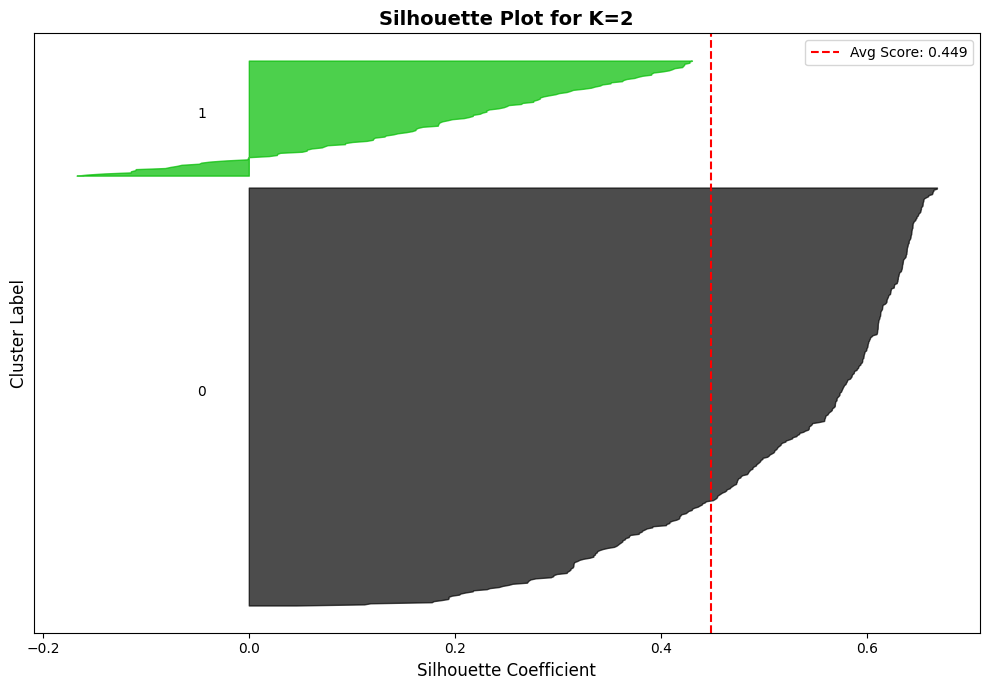

In [ ]:
# 4.3: Detailed Silhouette Analysis
print("\n[3/7] Detailed Silhouette Analysis...")

K_OPTIMAL = optimal_k_silhouette  # Use silhouette-based optimal K

# Create silhouette plot for optimal K
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

kmeans_optimal = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_scaled)

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(X_scaled, cluster_labels)
avg_silhouette = silhouette_score(X_scaled, cluster_labels)

y_lower = 10
for i in range(K_OPTIMAL):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / K_OPTIMAL)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title(f'Silhouette Plot for K={K_OPTIMAL}', fontsize=14, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster Label', fontsize=12)
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label=f'Avg Score: {avg_silhouette:.3f}')
ax.legend()
ax.set_yticks([])

plt.tight_layout()
plt.savefig('silhouette_plot.png', dpi=300, bbox_inches='tight')
print(f"✓ Silhouette plot saved as 'silhouette_plot.png'")
plt.show()

In [ ]:
# 4.4: Apply K-Means with Optimal K
print(f"\n[4/7] Applying K-Means with K={K_OPTIMAL}...")

kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)
cluster_centers = kmeans_final.cluster_centers_

# Add K-Means labels to metrics_df
metrics_df['KMeans_Cluster'] = kmeans_labels

print(f"K-Means clustering complete with K={K_OPTIMAL}")
print(f"Cluster centers shape: {cluster_centers.shape}")

# Print cluster sizes
unique, counts = np.unique(kmeans_labels, return_counts=True)
print(f"\nCluster sizes:")
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} stocks ({count/len(kmeans_labels)*100:.1f}%)")



[4/7] Applying K-Means with K=2...
K-Means clustering complete with K=2
Cluster centers shape: (2, 3)

Cluster sizes:
  Cluster 0: 386 stocks (78.3%)
  Cluster 1: 107 stocks (21.7%)


In [ ]:
# 4.5: Analyze K-Means Clusters
print(f"\n[5/7] Analyzing K-Means Clusters...")

print("="*60)
print(f"K-MEANS CLUSTER ANALYSIS (K={K_OPTIMAL})")
print("="*60)

# Calculate mean metrics for each cluster
kmeans_analysis = metrics_df.groupby('KMeans_Cluster')[features].mean()
kmeans_analysis['Count'] = metrics_df.groupby('KMeans_Cluster').size()
kmeans_analysis['Annualized_Return_Mean'] = metrics_df.groupby('KMeans_Cluster')['Annualized_Return'].mean()

print("\nCluster Characteristics (Mean Values):")
print(kmeans_analysis.round(4))

# Inverse transform cluster centers to original scale
centers_original = scaler.inverse_transform(cluster_centers)

print("\nCluster Centers (Original Scale):")
centers_df = pd.DataFrame(centers_original, columns=features)
print(centers_df.round(4))

# Interpret each cluster
print("\n" + "="*60)
print("K-MEANS CLUSTER INTERPRETATION FOR INVESTORS:")
print("="*60)

for cluster_id in range(K_OPTIMAL):
    cluster_data = kmeans_analysis.loc[cluster_id]

    print(f"\n🔹 CLUSTER {cluster_id} ({int(cluster_data['Count'])} stocks):")
    print(f"   Beta: {cluster_data['Beta']:.3f}")
    print(f"   Volatility: {cluster_data['Volatility']:.3f} ({cluster_data['Volatility']*100:.1f}%)")
    print(f"   Mean Daily Return: {cluster_data['Mean_Daily_Return']:.6f}")
    print(f"   Annualized Return: {cluster_data['Annualized_Return_Mean']:.3f} ({cluster_data['Annualized_Return_Mean']*100:.1f}%)")

    # Interpretation logic
    beta = cluster_data['Beta']
    vol = cluster_data['Volatility']

    if beta < 0.7 and vol < 0.25:
        risk_type = "🟢 DEFENSIVE/LOW RISK"
        description = "Stable stocks with low market sensitivity. Good for risk-averse investors."
        portfolio_weight = "40-50%"
    elif beta > 1.3 and vol > 0.4:
        risk_type = "🔴 AGGRESSIVE/HIGH RISK"
        description = "High-growth stocks with high volatility. Suitable for risk-tolerant investors."
        portfolio_weight = "10-15%"
    elif beta >= 0.7 and beta <= 1.3:
        risk_type = "🟡 MODERATE RISK"
        description = "Balanced stocks that move with the market. Core portfolio holdings."
        portfolio_weight = "35-45%"
    else:
        risk_type = "🟠 SPECIAL SITUATION"
        description = "Unusual risk/return profile. Requires individual analysis."
        portfolio_weight = "5-10%"

    print(f"   Type: {risk_type}")
    print(f"   Description: {description}")
    print(f"   Recommended Portfolio Weight: {portfolio_weight}")

    # Show top 5 stocks in this cluster
    cluster_stocks = metrics_df[metrics_df['KMeans_Cluster'] == cluster_id].nlargest(5, 'Volatility')
    print(f"   Sample High-Vol Stocks: {', '.join([str(t) for t in cluster_stocks['Ticker'].head(5).values])}")



[5/7] Analyzing K-Means Clusters...
K-MEANS CLUSTER ANALYSIS (K=2)

Cluster Characteristics (Mean Values):
                  Beta  Volatility  Mean_Daily_Return  Count  \
KMeans_Cluster                                                 
0               0.7740      0.2703             0.0003    386   
1               1.5157      0.4563             0.0007    107   

                Annualized_Return_Mean  
KMeans_Cluster                          
0                               0.0848  
1                               0.1668  

Cluster Centers (Original Scale):
     Beta  Volatility  Mean_Daily_Return
0  0.7740      0.2703             0.0003
1  1.5157      0.4563             0.0007

K-MEANS CLUSTER INTERPRETATION FOR INVESTORS:

🔹 CLUSTER 0 (386 stocks):
   Beta: 0.774
   Volatility: 0.270 (27.0%)
   Mean Daily Return: 0.000336
   Annualized Return: 0.085 (8.5%)
   Type: 🟡 MODERATE RISK
   Description: Balanced stocks that move with the market. Core portfolio holdings.
   Recommended Portf


[6/7] Creating K-Means Visualizations...
✓ K-Means visualizations saved as 'kmeans_clusters.png'


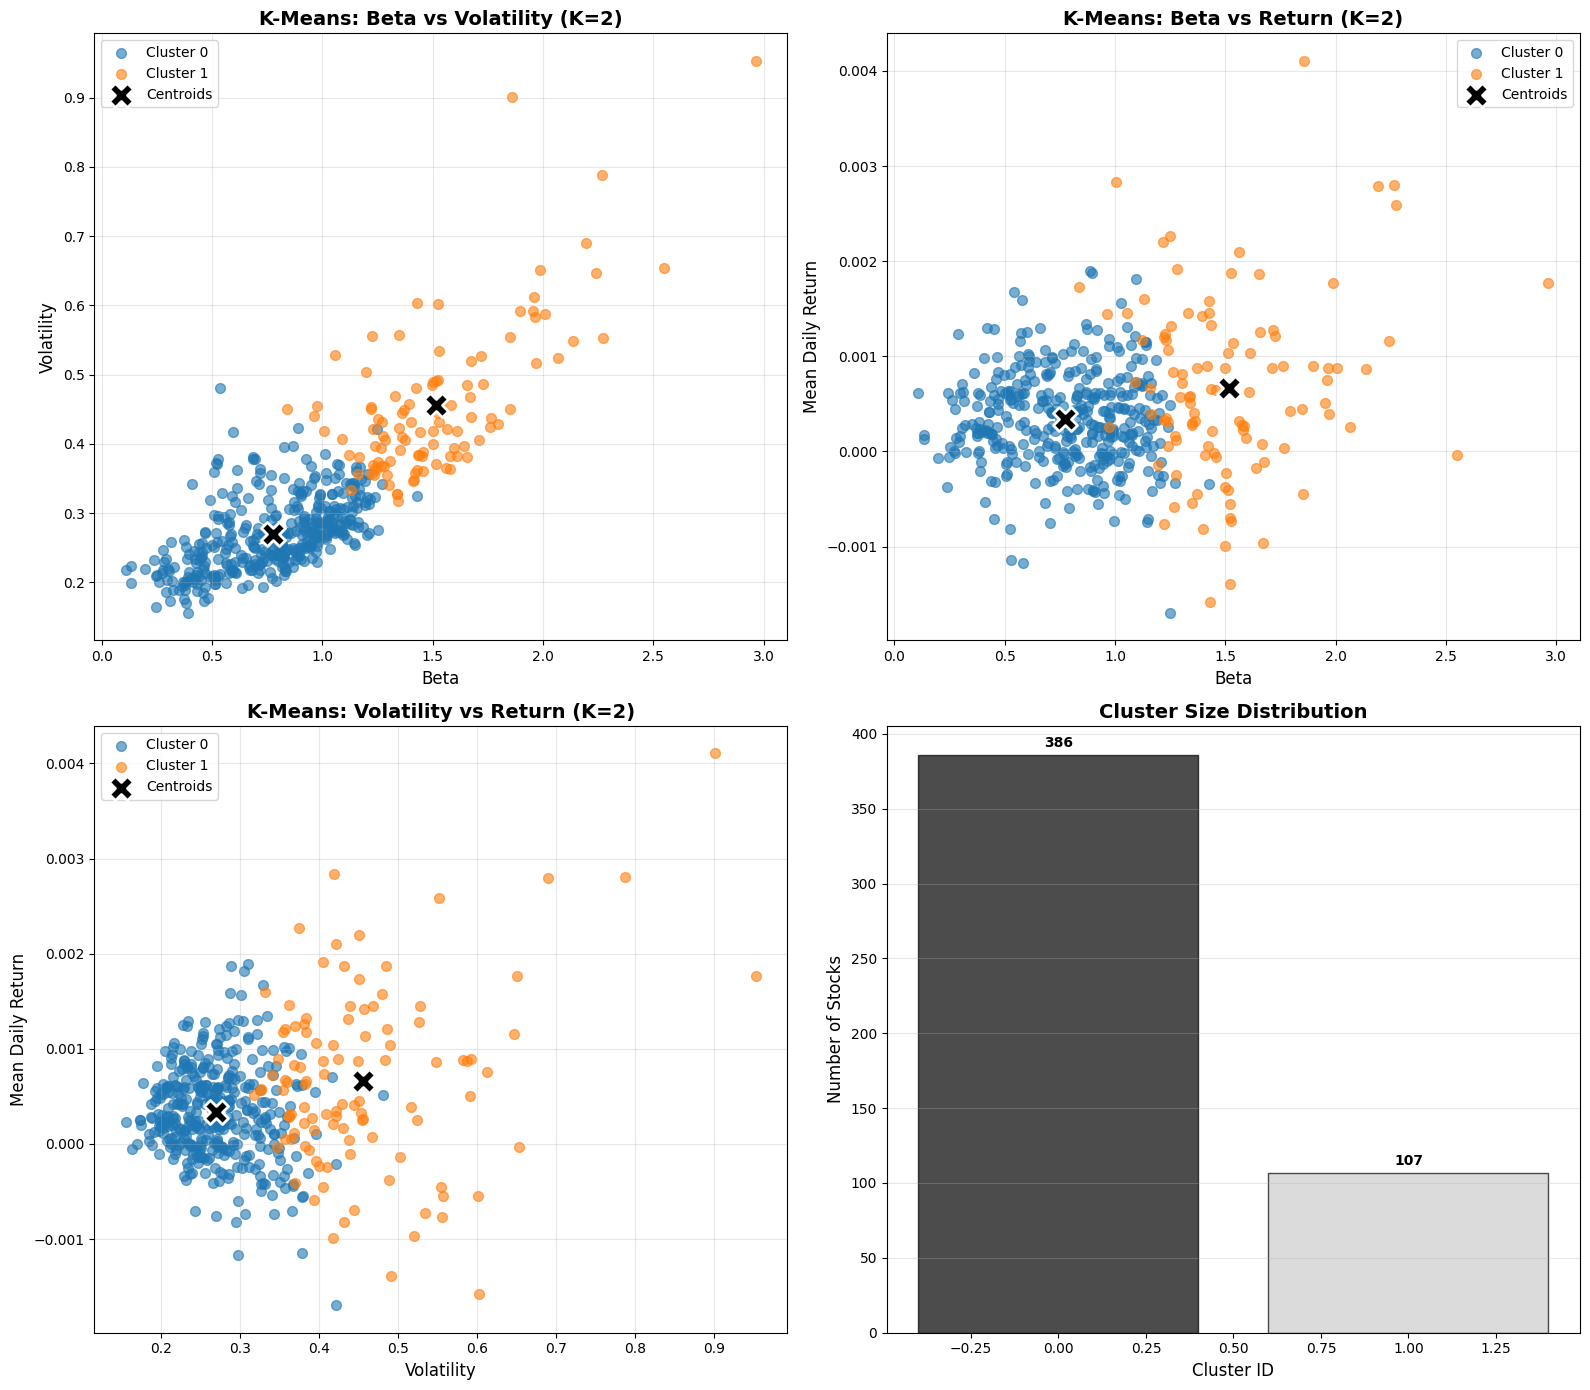

In [ ]:
# 4.6: Visualize K-Means Clusters
print(f"\n[6/7] Creating K-Means Visualizations...")

# Create comprehensive scatter plots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Beta vs Volatility with cluster centers
for cluster_id in range(K_OPTIMAL):
    cluster_data = metrics_df[metrics_df['KMeans_Cluster'] == cluster_id]
    axes[0, 0].scatter(
        cluster_data['Beta'],
        cluster_data['Volatility'],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50
    )

# Plot cluster centers
centers_orig = scaler.inverse_transform(cluster_centers)
axes[0, 0].scatter(centers_orig[:, 0], centers_orig[:, 1],
                   c='black', marker='X', s=300, linewidths=2,
                   edgecolors='white', label='Centroids', zorder=10)

axes[0, 0].set_xlabel('Beta', fontsize=12)
axes[0, 0].set_ylabel('Volatility', fontsize=12)
axes[0, 0].set_title(f'K-Means: Beta vs Volatility (K={K_OPTIMAL})', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Beta vs Mean Daily Return
for cluster_id in range(K_OPTIMAL):
    cluster_data = metrics_df[metrics_df['KMeans_Cluster'] == cluster_id]
    axes[0, 1].scatter(
        cluster_data['Beta'],
        cluster_data['Mean_Daily_Return'],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50
    )

axes[0, 1].scatter(centers_orig[:, 0], centers_orig[:, 2],
                   c='black', marker='X', s=300, linewidths=2,
                   edgecolors='white', label='Centroids', zorder=10)

axes[0, 1].set_xlabel('Beta', fontsize=12)
axes[0, 1].set_ylabel('Mean Daily Return', fontsize=12)
axes[0, 1].set_title(f'K-Means: Beta vs Return (K={K_OPTIMAL})', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Volatility vs Return
for cluster_id in range(K_OPTIMAL):
    cluster_data = metrics_df[metrics_df['KMeans_Cluster'] == cluster_id]
    axes[1, 0].scatter(
        cluster_data['Volatility'],
        cluster_data['Mean_Daily_Return'],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50
    )

axes[1, 0].scatter(centers_orig[:, 1], centers_orig[:, 2],
                   c='black', marker='X', s=300, linewidths=2,
                   edgecolors='white', label='Centroids', zorder=10)

axes[1, 0].set_xlabel('Volatility', fontsize=12)
axes[1, 0].set_ylabel('Mean Daily Return', fontsize=12)
axes[1, 0].set_title(f'K-Means: Volatility vs Return (K={K_OPTIMAL})', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cluster size bar chart
cluster_sizes = metrics_df['KMeans_Cluster'].value_counts().sort_index()
colors = plt.cm.nipy_spectral(np.linspace(0, 1, K_OPTIMAL))
axes[1, 1].bar(cluster_sizes.index, cluster_sizes.values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Cluster ID', fontsize=12)
axes[1, 1].set_ylabel('Number of Stocks', fontsize=12)
axes[1, 1].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(cluster_sizes.values):
    axes[1, 1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('kmeans_clusters.png', dpi=300, bbox_inches='tight')
print("✓ K-Means visualizations saved as 'kmeans_clusters.png'")
plt.show()



[7/7] Comparing K-Means vs Agglomerative Clustering...

COMPARISON: K-MEANS vs AGGLOMERATIVE

Cross-tabulation (overlap between methods):
Agglomerative   0    1   2    3
K-Means                        
0               0  175  40  171
1              47    0  47   13

Adjusted Rand Index (similarity): 0.248
(Range: -1 to 1, where 1 = identical clustering, 0 = random)

✓ Comparison plot saved as 'clustering_comparison.png'


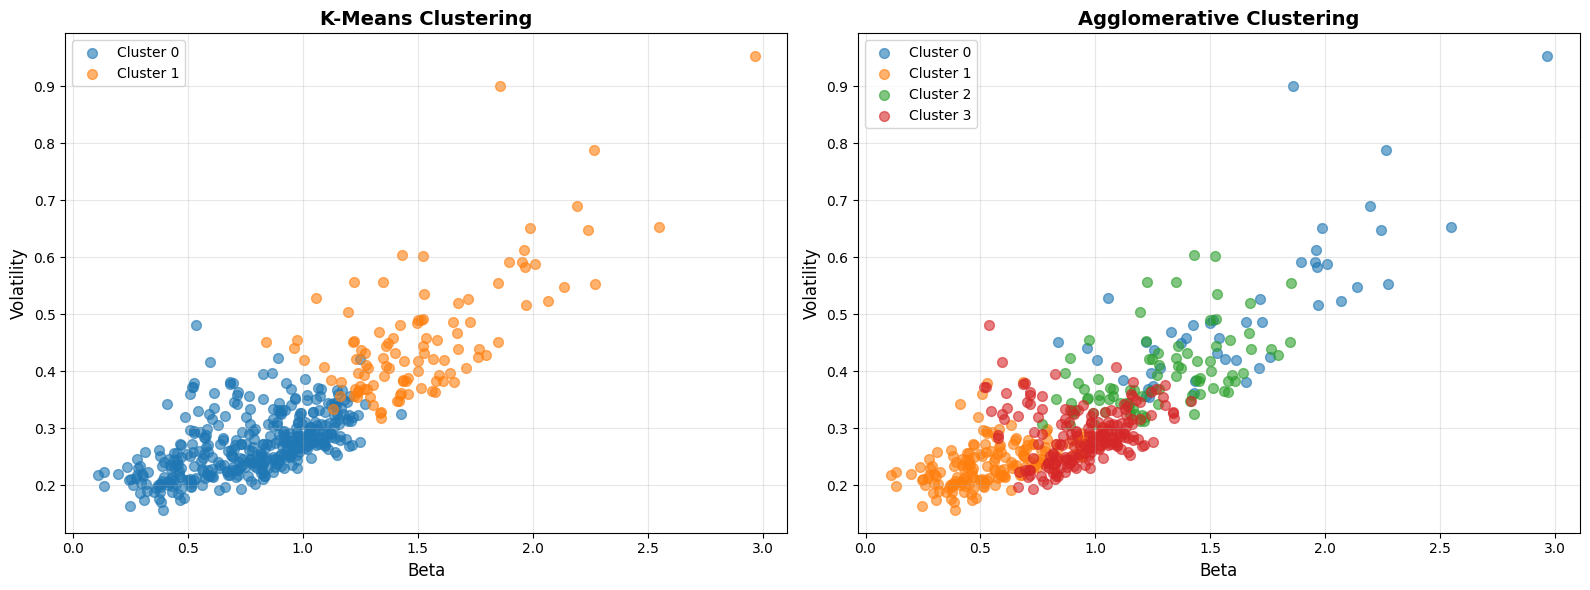


✓ Step 4 Complete: K-Means Clustering Finished!
✓ Optimal K: 2
✓ Silhouette Score: 0.449
✓ Cluster labels added to 'metrics_df' as 'KMeans_Cluster'
✓ All visualizations saved as PNG files

📊 PORTFOLIO DIVERSIFICATION STRATEGY:
   1. Identify your risk tolerance
   2. Select stocks from multiple clusters
   3. Defensive core (40-50%) + Moderate growth (35-45%) + Aggressive (10-15%)
   4. Rebalance quarterly based on cluster movements


In [ ]:
# 4.7: Compare K-Means vs Agglomerative Clustering
print(f"\n[7/7] Comparing K-Means vs Agglomerative Clustering...")

# Check if we have agglomerative results
agg_col = 'Cluster_K4'  # Adjust based on your Step 3 choice
if agg_col in metrics_df.columns:
    print("\n" + "="*60)
    print("COMPARISON: K-MEANS vs AGGLOMERATIVE")
    print("="*60)

    # Cross-tabulation
    comparison = pd.crosstab(metrics_df['KMeans_Cluster'],
                            metrics_df[agg_col],
                            rownames=['K-Means'],
                            colnames=['Agglomerative'])

    print("\nCross-tabulation (overlap between methods):")
    print(comparison)

    # Calculate agreement percentage
    from sklearn.metrics import adjusted_rand_score
    ari = adjusted_rand_score(metrics_df['KMeans_Cluster'], metrics_df[agg_col])
    print(f"\nAdjusted Rand Index (similarity): {ari:.3f}")
    print("(Range: -1 to 1, where 1 = identical clustering, 0 = random)")

    # Side-by-side visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # K-Means
    for cluster_id in range(K_OPTIMAL):
        cluster_data = metrics_df[metrics_df['KMeans_Cluster'] == cluster_id]
        axes[0].scatter(cluster_data['Beta'], cluster_data['Volatility'],
                       label=f'Cluster {cluster_id}', alpha=0.6, s=50)
    axes[0].set_xlabel('Beta', fontsize=12)
    axes[0].set_ylabel('Volatility', fontsize=12)
    axes[0].set_title('K-Means Clustering', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Agglomerative
    n_agg_clusters = metrics_df[agg_col].nunique()
    for cluster_id in range(n_agg_clusters):
        cluster_data = metrics_df[metrics_df[agg_col] == cluster_id]
        axes[1].scatter(cluster_data['Beta'], cluster_data['Volatility'],
                       label=f'Cluster {cluster_id}', alpha=0.6, s=50)
    axes[1].set_xlabel('Beta', fontsize=12)
    axes[1].set_ylabel('Volatility', fontsize=12)
    axes[1].set_title('Agglomerative Clustering', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('clustering_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Comparison plot saved as 'clustering_comparison.png'")
    plt.show()
else:
    print("\nNote: Agglomerative clustering results not found for comparison.")

print("\n" + "="*60)
print("✓ Step 4 Complete: K-Means Clustering Finished!")
print("="*60)
print(f"✓ Optimal K: {K_OPTIMAL}")
print(f"✓ Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.3f}")
print(f"✓ Cluster labels added to 'metrics_df' as 'KMeans_Cluster'")
print(f"✓ All visualizations saved as PNG files")
print("\n📊 PORTFOLIO DIVERSIFICATION STRATEGY:")
print("   1. Identify your risk tolerance")
print("   2. Select stocks from multiple clusters")
print("   3. Defensive core (40-50%) + Moderate growth (35-45%) + Aggressive (10-15%)")
print("   4. Rebalance quarterly based on cluster movements")